# Calculating properties of loops

This notebook demonstrates the different ways of calculating properties of loops in numpy
The script `generate_fake_loop.py` was used to generate a loop with artificial noise and missingness from parametric equation: 

$$
\begin{align}
x & = \cos(\theta) + \sin(\theta)\\
y & = \sin(\theta)
\end{align}
$$

where $\theta$ is in the range $[0, 2\pi]$

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import csv

Importing data:

In [3]:
DATA = 'data/loop_data.csv'
data = np.genfromtxt(DATA, delimiter=',')
x = data[:, 0]
y = data[:, 1]

In [4]:
data.shape

(1001, 2)

## Plotting the data

Lets see how the data compares to a smooth parametric plot

Text(0, 0.5, 'y')

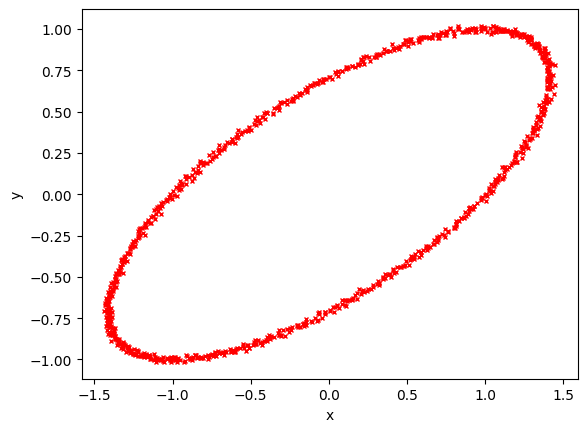

In [5]:
plt.plot(x, y, 'rx', markersize = 3)
plt.xlabel('x')
plt.ylabel('y')

### Missingness handling

What if we get rid of the missing data?

Its important that when we drop missing data, we drop it from both `x` and `y`
This is because things can get 'out of sync' otherwise 
- In other words, if we drop $x_i$, we also want to drop $y_i$
- Below is an example of what **not** to do

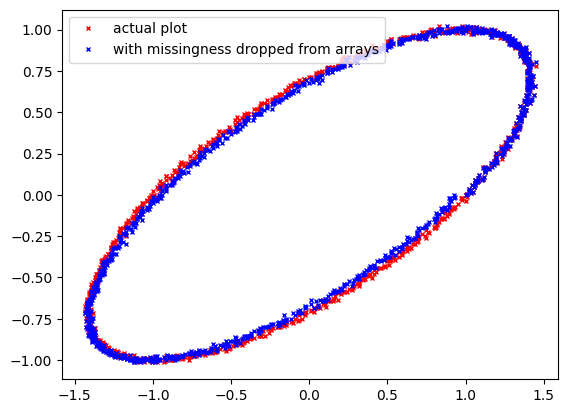

In [6]:
xfiltered = x[~np.isnan(x)][:980]
yfiltered = y[~np.isnan(y)][:980]
plt.plot(x, y, 'rx', markersize=3,
         label='actual plot')
plt.plot(xfiltered,yfiltered, 'bx', markersize=3, label = 'with missingness dropped from arrays')
plt.legend()
plt.show()

Instead, we can filter like this:

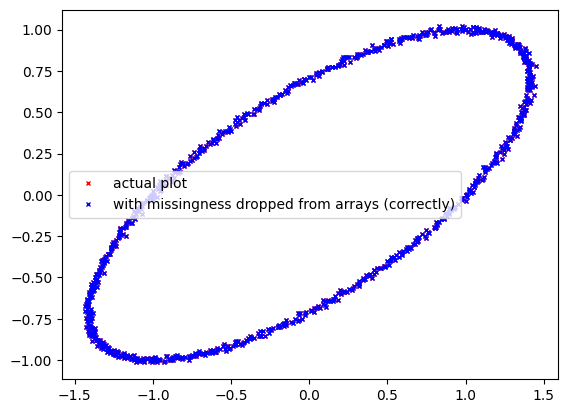

In [7]:
# For structured arrays, build the mask field-by-field
mask = (~np.isnan(data[:,0])) & (~np.isnan(data[:,1]))
filtered_data = data[mask]
plt.plot(x, y, 'rx', markersize=3,
         label='actual plot')
plt.plot(filtered_data[:, 0], filtered_data[:, 1], 'bx', markersize=3,
         label='with missingness dropped from arrays (correctly)')
plt.legend()
plt.show()

### Area calculation

What is the actual, expected area enclosed in the curve?


$$
\begin{align}
x & = \cos(\theta) + \sin(\theta)\\
y & = \sin(\theta)
\end{align}
$$

Any area is just 

$$
A = \int x(\theta) y'(\theta) d\theta
$$

So $A = \pi$ is the true area.

How can we estimate this?

In [8]:
trapezoid_method_estimate = np.trapezoid(filtered_data[:, 1], filtered_data[:, 0])
trapezoid_method_estimate

np.float64(-3.1403015170585)

Why is the above negative? 
- Closed Loops: the area always depends on the traversal direction - counterclockwise traversal means that the loops have a positive area (this is because, for increasing `dy`, you have a positive contribution of `xdy` )
- `np.trapezoid` integrates in the direction that the data goes in. For example, if we supply `filtered_data` where following indeces 0 -> 100 is going clockwise, then we are integrating in the clockwise direction and will get a negative are. 
- How can we get around this?
    - Quick fix: take `abs(trapezoid_method_estimate)` 

### Alternative: the shoelace method

TODO: write up explanation

In [11]:
y, x = filtered_data[:, 1], filtered_data[:, 0]
x_c = np.concatenate([x, x[:1]])
y_c = np.concatenate([y, y[:1]])
area = 0.5 * np.sum(x_c[:-1]*y_c[1:] - x_c[1:]*y_c[:-1])
area

np.float64(3.1402947024585)

## Maximum and minimum gradient 

To work out the max and minimum gradient, we have one big difficulty: the `data` isn't necessarily ordered 
(e.g. following the data points as the index gets higher doesn't necessarily mean that we're tracing out the loop in order). 
So, as a first step, order all of the coordinates so that they trace out a counterclockwise loop:

In [32]:
y, x = filtered_data[:, 1], filtered_data[:, 0]

# compute the 'centroid' - the center of the loop
cx, cy = filtered_data.mean(axis=0)

below visualises the centroid:

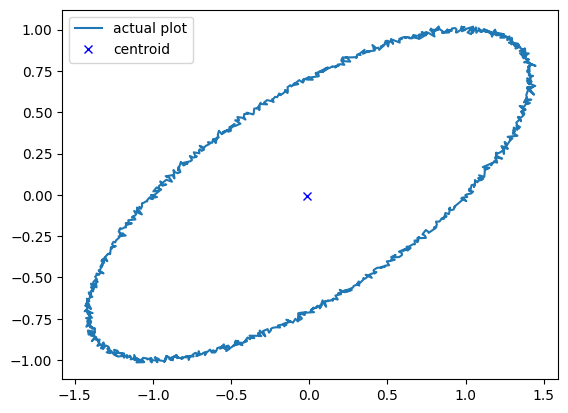

In [33]:
plt.plot(x, y, '-', label='actual plot')
plt.plot(cx, cy, 'bx', label = 'centroid')
plt.legend()
plt.show()

Now work out the angle that each point makes with the centroid

$$
\theta = \tan^{-1}(\frac{y-y_c}{x - x_c})
$$

In [34]:
theta = np.arctan2(filtered_data[:, 1] - cy, filtered_data[:, 0] - cx)

Finally, order the points according to the angle:

In [35]:
order = np.argsort(theta)
ordered_loop = filtered_data[order]

This doesn't change anything about the plot itself - just rearranges it so that we can use `np.gradient` more easily

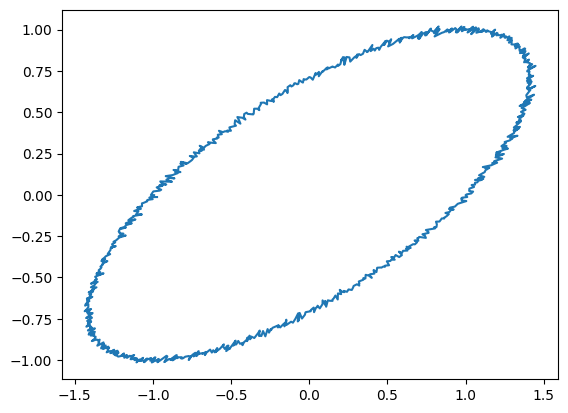

In [37]:
# showing nothing about the plot has changed
x, y = ordered_loop[:,0], ordered_loop[:,1]
plt.plot(x,y)
plt.show()

Now, we need to take one caveat into account:
- A hysterisis loop is a closed curve
- This means tha the function isn't single valued - one value of `x` has multiple values of `y` 

Why does this matter for gradients?
- Sometimes, we might have a loop going rightwards `dx > 0` and then 'doubling back' with `dx < 0` 
- Between these two cases, we must cross `dx = 0` 
- All of this means that the slope can blow up $dy/dx \to \inf$ and become undefined when considering just discrete points

How do we get around this issue?
- Treat the loop parametrically 
- if `t` is the index of our array:

```
x = x(t)
y = y(t)
```

- then, the slope is 

```
dy/dx = (dy/dt) / (dx/dt)
```

Note that this depends on us moving 'around the loop in the right order', since `np.gradient` works by comparing adjacent points

In [39]:
dx = np.gradient(x)
dy = np.gradient(y)

In [43]:
slope = dy/dx
max_grad = np.nanmax(slope)
min_grad = np.nanmin(slope)

max_idx = np.argmax(slope)
min_idx = np.argmin(slope)

We can visualise the points found:

In [42]:
np.nanmax(slope)

np.float64(967.5714285742976)

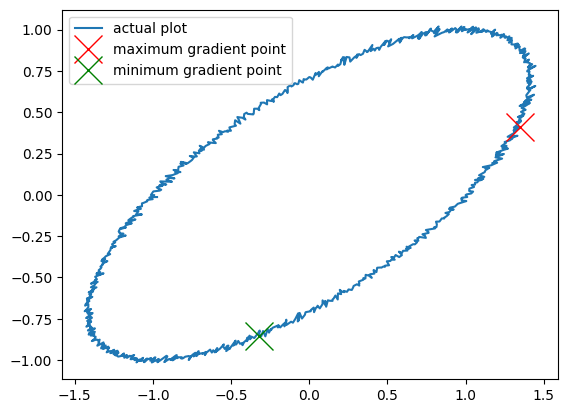

In [45]:
# Draw loop and tangent lines at max/min slope points
plt.plot(x, y, '-', label='actual plot')
plt.plot(x[max_idx], y[max_idx], 'rx', markersize=20,
         label='maximum gradient point')
plt.plot(x[min_idx], y[min_idx], 'gx', markersize=20,
         label='minimum gradient point')
plt.legend()